In [29]:
import pandas as pd
import torch
from itertools import zip_longest

# local imports
from src.dataset import load_dataset
from src.train   import train_model
from src.models  import ATISMultiTaskModel as Model
from src.models  import SentenceEncoder as Encoder
from src.utils   import plot_metrics

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

In [49]:
train_ds, val_ds = load_dataset('data')

In [50]:

'''Demonstration puspose only'''

record = train_ds[5]
gt = record['gt']

words      = gt[1].split()

# pull out the first 12 of each
tokens     = record['input_ids'].tolist()[:12]
entities   = gt[2][:12]
entity_ids = record['slot_labels'].tolist()[:12] # type: ignore
mask       = record['attention_mask'].tolist()[:12]

# zip them together and print a table
header = f"{'Word':^15s} | {'TokenID':^7s} | {'Entity':^12s} | {'EntID':^6s} | {'Mask':^4s}"
print(header)
print("-" * len(header))
for w, t, e, eid, m in zip_longest(words, tokens, entities, entity_ids, mask, fillvalue="[PAD]"):
    print(f"{w:^15s} | {str(t):^7s} | {e:^12s} | {str(eid):^6s} | {str(m):^3s}")

     Word       | TokenID |    Entity    | EntID  | Mask
--------------------------------------------------------
       i        |  1045   |      X       |   4    |  1 
     need       |  2342   |      X       |   4    |  1 
       a        |  1037   |      X       |   4    |  1 
    flight      |  3462   |      X       |   4    |  1 
   tomorrow     |  4826   |   DateTime   |   6    |  1 
     from       |  2013   |      X       |   4    |  1 
   columbus     |  8912   |   Location   |   2    |  1 
      to        |  2000   |      X       |   4    |  1 
  minneapolis   |  11334  |   Location   |   2    |  1 
     [PAD]      |    0    |    [PAD]     |   0    |  0 
     [PAD]      |    0    |    [PAD]     |   0    |  0 
     [PAD]      |    0    |    [PAD]     |   0    |  0 


##### Dataset Overview

This project uses a **curated subset** of the Airline Travel Information System (ATIS) corpus. Each example consists of a user’s flight-related utterance, annotated with:

- **Intent**: the user’s overall goal (e.g. searching for flights, checking fares).  
- **Entities**: token-level labels indicating semantic categories (e.g. cities, times).

---

##### Example Record

```json
{
  "text": "i need a flight tomorrow from columbus to minneapolis",
  "entities": ["X", "X", "X", "X", "DateTime", "X", "Location", "X", "Location"],
  "intent":   "Flight"
}
```
---


Here:

- **text**: raw user utterance  
- **entities**: one tag per token (’X’ = no entity)  
- **intent**: high-level query category  
> **Note:** `X` corresponds to 'other (uninteresting)' category.

##### Modeling Tasks

1. Intent Classification  
   Build a classifier that takes an utterance and predicts its **intent** label (0–7).

2. Named Entity Recognition (NER)  
   Perform token-level labeling to assign each word in the utterance one of the **entity** tags (0–9).


##### Dataset
The data set consists of below keys
- **input_ids**: the text tokenized using bert tokenizer consisting of a vocab of size 30522
- **attention_mask**: 1 where word valid 0 for padding
- **intent_label**: label encoded intent
- **slot_labels**: label encoded entities / slot

All sentences are padded to `100` while 0 represents padding for all positions except intent_label
> **Assumption**: BERT tokenizer adds special tokens ([CLS], [SEP]) which has been disabled and a naive `one-entity-per-word` is assumed. 

please note: through out the project slot and entity are used to convey the same thing. 
The original dataset as slot hence the ambiguity. 


For additional filtering steps and exploratory data analysis, please see `notebooks/dataset.ipynb`.

### Task 1: Sentence Transformer Implementation

In [27]:
encoder = Encoder("custom", 128).to(device)

above is the encoder transformer constisting of a simple transformer archecture.
embedding layer 
Positional encoding 


In [16]:
record         = val_ds[130]
input_ids      = record['input_ids'].unsqueeze(0).to(device)
attention_mask = record['attention_mask'].unsqueeze(0).to(device)

with torch.no_grad():
    embeddings = encoder(input_ids, attention_mask)
    
embeddings.shape

torch.Size([1, 128])

### Task 2: Multi-Task Learning Expansion 

In [17]:
model = Model(encoder).to(device)

In [ ]:
metrics = train_model(train_ds, val_ds, model, epochs=5)

### Task 3: Training Considerations 

### Task 4: Training Loop Implementation (BONUS)

### Metrics 

In [11]:
df = pd.DataFrame(metrics)
df.round(2)

,train_loss,train_intent_loss,train_entity_loss,train_intent_acc,train_entity_f1,val_loss,val_intent_loss,val_entity_loss,val_intent_acc,val_entity_f1,epoch
0,1.83,1.08,0.75,0.70,0.18,1.51,1.04,0.47,0.71,0.19,0
1,1.40,0.91,0.49,0.73,0.18,1.49,1.03,0.46,0.71,0.19,1
2,1.38,0.90,0.48,0.73,0.18,1.48,1.03,0.45,0.71,0.19,2
3,1.38,0.90,0.47,0.73,0.18,1.47,1.02,0.45,0.71,0.19,3
4,1.37,0.90,0.47,0.73,0.18,1.47,1.02,0.45,0.71,0.19,4


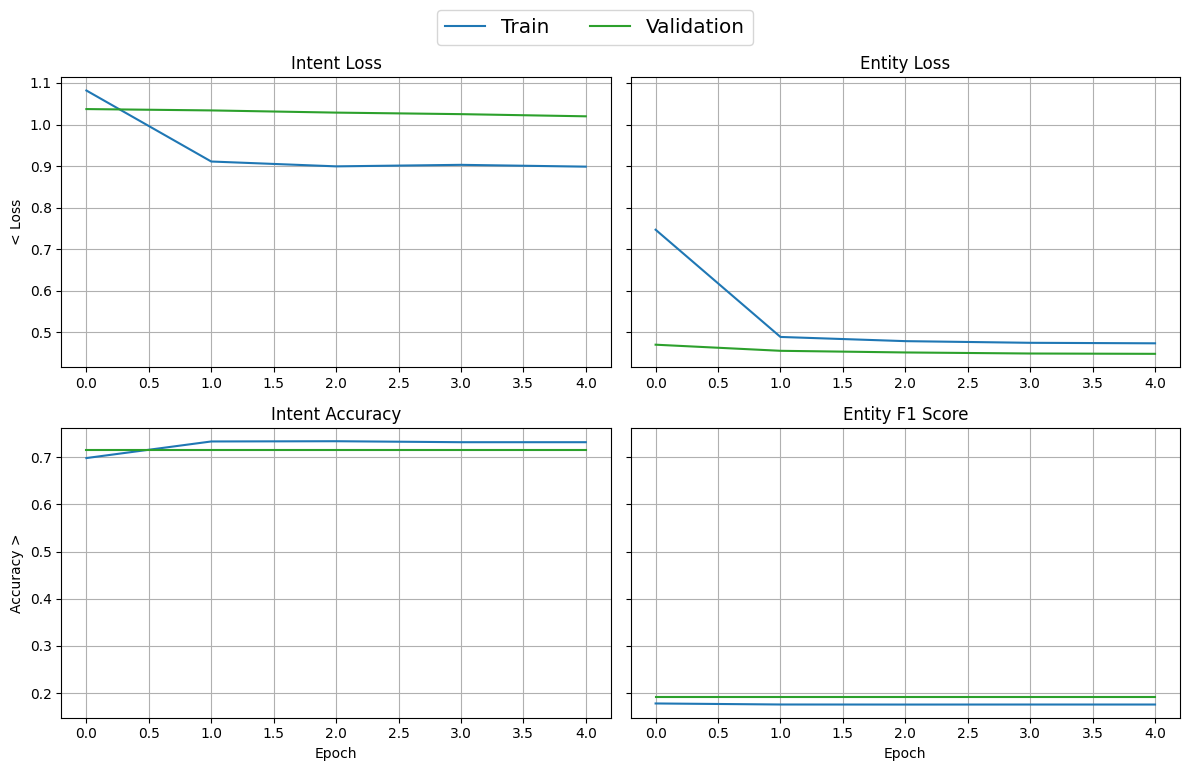

In [12]:

plot_metrics(metrics)